In [9]:
import collections
import random
from itertools import combinations

import numpy as np
import pandas as pd
import seaborn as sns
from kaggle_environments import make
from kaggle_environments.envs.rps.utils import get_score
import matplotlib.pyplot as plt

Создадим несколько агентов, который будут "играть" в игру камень/ножницы/бумага.

Я использую классы, у которых переопределён магический метод `__call__` для того, что бы можно было вызвать экзэмпляр данного класса как функцию.
Я решил использовать классы потому что мне не хотелось объявлять глобальные переменные, реализация с переменными класса показалась мне наиболее идеоматичной.

In [10]:
ROCK, PAPER, SCISSORS = 0, 1, 2


class RandomChoiceAgent:
    """
    Агент случайно выбирает значение из камня, ножниц или бумаги
    на каждой итерации
    """

    name = "random"

    def __call__(self, observation, configuration):
        return random.choice([ROCK, PAPER, SCISSORS])


class OnlyScissorsAgent:
    """
    Агент всегда выбирает ножницы
    """

    name = "scissors"

    def __call__(self, observation, configuration):
        return SCISSORS


class OnlyRockAgent:
    """
    Агент всегда выбирает камень
    """

    name = "rock"

    def __call__(self, observation, configuration):
        return ROCK


class OnlyPaperkAgent:
    """
    Агент всегда выбирает бумагу
    """

    name = "paper"

    def __call__(self, observation, configuration):
        return PAPER


class EveryThirdRockAgent:
    """
    Агент на каждом третьем шаге выбирает камень.
    На остальных шагах - случайное значение.
    """

    name = "third rock"

    def __call__(self, observation, configuration):
        if observation.step % 3 == 0:
            return ROCK
        return random.choice([ROCK, PAPER, SCISSORS])


class StatisticalAgent:
    """
    Агент запоминает ходы противника, и противодействует наиболее
    часто встречающемуся действию противника.
    """

    name = "statistical"
    action_histogram = {}

    def __call__(self, observation, configuration):
        if observation.step == 0:
            self.action_histogram = {}
            return
        action = observation.lastOpponentAction
        if action not in self.action_histogram:
            self.action_histogram[action] = 0
        self.action_histogram[action] += 1
        mode_action = None
        mode_action_count = None
        for k, v in self.action_histogram.items():
            if mode_action_count is None or v > mode_action_count:
                mode_action = k
                mode_action_count = v
                continue
        return (mode_action + 1) % configuration.signs


class Reactionary:
    """
    Запоминает последние действия противника.
    Если предыдущий ход был проигран, выбирает новый ход.
    """

    name = "reactionary"
    last_react_action = None

    def __call__(self, observation, configuration):
        if observation.step == 0:
            self.last_react_action = random.choice([ROCK, PAPER, SCISSORS])
        elif get_score(self.last_react_action, observation.lastOpponentAction) <= 1:
            self.last_react_action = (
                observation.lastOpponentAction + 1
            ) % configuration.signs

        return self.last_react_action


class CounterReactionary:
    """
    Принимает решение на основе разницы между ходами.
    """

    name = "c. reactionary"
    last_counter_action = None

    def __call__(self, observation, configuration):
        if observation.step == 0:
            self.last_counter_action = random.choice([ROCK, PAPER, SCISSORS])
        elif get_score(self.last_counter_action, observation.lastOpponentAction) == 1:
            self.last_counter_action = (
                self.last_counter_action + 2
            ) % configuration.signs
        else:
            self.last_counter_action = (
                observation.lastOpponentAction + 1
            ) % configuration.signs

        return self.last_counter_action


class CopyOpponent:
    """
    Агент подрожатель.
    Копирует действия противника в предыдущем ходе
    """

    name = "copy opponent"

    def __call__(self, observation, configuration):
        if observation.step > 0:
            return observation.lastOpponentAction
        else:
            return random.choice([ROCK, PAPER, SCISSORS])


class CycledAgent:
    """
    Циклично перебирает все значения - камень, бумага, ножницы
    """

    name = "cycled"
    cycle_counter = 0

    def __call__(self, observation, configuration):
        sign = self.cycle_counter
        self.cycle_counter += 1
        if self.cycle_counter >= 3:
            self.cycle_counter = 0
        return sign


class ReverseCycledAgent:
    """
    Циклично перебирает все значения в обратном порядке - ножницы, бумага, камень
    """

    name = "r. cycled"
    cycle_counter = 2

    def __call__(self, observation, configuration):
        sign = self.cycle_counter
        self.cycle_counter -= 1
        if self.cycle_counter <= -1:
            self.cycle_counter = 2
        return sign


class JhonsonAgent:
    """
    Агент с анализом паттернов противника. Использует таблицу частот для предсказания.
    """

    name = "Jhonson"
    action_seq = []
    table = collections.defaultdict(lambda: [1, 1, 1])

    def __call__(self, observation, configuration):
        k = 2
        if observation.step % 25 == 0:
            self.action_seq, self.table = [], collections.defaultdict(
                lambda: [1, 1, 1]
            )  # обновляет таблицу каждые 25 шагов
        if len(self.action_seq) <= 2 * k + 1:
            action = int(np.random.randint(3))
            if observation.step > 0:
                self.action_seq.extend(
                    [observation.lastOpponentAction, action]
                )  # добавляет последний ход противника
            else:
                self.action_seq.append(action)
            return action

        key = "".join(
            [str(a) for a in self.action_seq[:-1]]
        )  # ключ на основе последовательности ходов
        self.table[key][
            observation.lastOpponentAction
        ] += 1  # обновляет таблицу по ключу

        self.action_seq[:-2] = self.action_seq[2:]
        self.action_seq[-2] = observation.lastOpponentAction
        key = "".join([str(a) for a in self.action_seq[:-1]])

        if observation.step < 50:
            next_opponent_action_pred = np.argmax(
                self.table[key]
            )  # предсказание по таблице
        else:
            scores = np.array(self.table[key])
            next_opponent_action_pred = np.random.choice(3, p=scores / scores.sum())

        action = (next_opponent_action_pred + 1) % 3
        if observation.step > 90:
            action = next_opponent_action_pred
        self.action_seq[-1] = action
        return int(action)


class ScissorsPaperRandomAgent:
    """
    Случайно выбирает между ножницами и бумагой
    """

    name = "scissors/paprer"

    def __call__(self, observation, configuration):
        return random.choice([SCISSORS, PAPER])


class RockPaperRandomAgent:
    """
    Случайно выбирает между камнем и бумагой
    """

    name = "rock/paprer"

    def __call__(self, observation, configuration):
        return random.choice([ROCK, PAPER])


class ScissorsRockRandomAgent:
    """
    Случайно выбирает между ножницами и камнем
    """

    name = "scissors/rock"

    def __call__(self, observation, configuration):
        return random.choice([SCISSORS, ROCK])

Даеле объеденим все созданные агенты в одну структуру типа `set` для дальнейшей итерации.

In [11]:
all_agents = {
    RandomChoiceAgent,
    OnlyScissorsAgent,
    OnlyRockAgent,
    OnlyPaperkAgent,
    EveryThirdRockAgent,
    StatisticalAgent,
    Reactionary,
    CounterReactionary,
    CopyOpponent,
    CycledAgent,
    ReverseCycledAgent,
    JhonsonAgent,
    ScissorsPaperRandomAgent,
    RockPaperRandomAgent,
    ScissorsRockRandomAgent,
}

Так же я решил написать функцию `count_scores` которая будет производить подсчёт, сколько же в итоге из 1000 проведённых игр выиграл агент и его аппонент. Мне кажется что такие данные добавляют наглядности.

In [12]:
def count_scores(step_results):
    agent_1_wins = 0
    agent_2_wins = 0
    for result in step_results[1:]:
        score = get_score(result[0]["action"], result[1]["action"])
        match score:
            case 0:
                continue
            case 1:
                agent_1_wins += 1
            case -1:
                agent_2_wins += 1
    return agent_1_wins, agent_2_wins

Основной цикл соревнований.
Каждый агент будет играть с оппонентом 1000 игр.

Здесь мы перебираем все уникальные пары агентов из вышесоставленного `set`. Для каждой пары агентов проводим соревнование. Далее подсчитываем количество выигрышей.
Создаём результирующую таблицу `result_table` и заносим результаты соревнований для каждой пары агент/оппонент. Стоит отметить что я делаю как бы двойную зеркальную запись как для агента так и для оппонента, мне кажется что такое решение добавляет наглядности в результирующей таблице, хоть и избыточно.

In [13]:
result_table = {
    "agent": [],
    "opponent": [],
    "games_won": [],
    "opponent_games_won": [],
    "scores": [],
    "opponent_scores": [],
}

for agent1, agent2 in combinations(all_agents, 2):
    env = make("rps", configuration={"episodeSteps": 1000, "tieRewardThreshold": 1})
    steps = env.run([agent1(), agent2()])
    scores = count_scores(steps)
    # добавим запись в результирующую таблицу про счёт агента
    result_table["agent"].append(agent1.name)
    result_table["opponent"].append(agent2.name)
    result_table["games_won"].append(scores[0])
    result_table["opponent_games_won"].append(scores[1])
    result_table["scores"].append(steps[-1][0]["reward"])
    result_table["opponent_scores"].append(steps[-1][1]["reward"])
    # и так же добавим запись в таблицу про счёт оппонента
    # эта запись "зеркальна" по отношению к записи агента
    result_table["agent"].append(agent2.name)
    result_table["opponent"].append(agent1.name)
    result_table["games_won"].append(scores[1])
    result_table["opponent_games_won"].append(scores[0])
    result_table["scores"].append(steps[-1][1]["reward"])
    result_table["opponent_scores"].append(steps[-1][0]["reward"])

df = pd.DataFrame(result_table)
df.sort_values(["agent", "opponent"], ascending=False, ignore_index=True)

,agent,opponent,games_won,opponent_games_won,scores,opponent_scores
0,third rock,statistical,218,551,-333.0,333.0
1,third rock,scissors/rock,374,225,149.0,-149.0
2,third rock,scissors/paprer,392,383,9.0,-9.0
3,third rock,scissors,558,209,349.0,-349.0
4,third rock,rock/paprer,220,399,-179.0,179.0
...,...,...,...,...,...,...
205,Jhonson,r. cycled,320,309,11.0,-11.0
206,Jhonson,paper,300,247,53.0,-53.0
207,Jhonson,cycled,303,315,-12.0,12.0
208,Jhonson,copy opponent,337,293,44.0,-44.0


После проведённый соревнований агентов, построим сводную таблицу для того бы построить график типа `heatmap` для наглядности.
При построении сводной таблицы используем параметр `fill_value=0` для того что бы заполнить таблицу нулями на пересечении агента с самим собой. По задумке агент не соревнуется сам с собой.

In [14]:
scores_comparison = df.pivot_table(
    index="agent", columns="opponent", values="scores", fill_value=0
)

На графике `heatmap` видно что:
1. Агент `coppy opponent` показывает себя хорошо против агента `c. reactionary` и `r. cycled`
2. Агент `statistical` имеет больше всех общих выигрышей против всех других агентов, он серьёзно проиграл только `reactionary` (что интересно).
3. Агент `random` держится примерно в самой середине распределения по выигрышам, что кажется естественным.

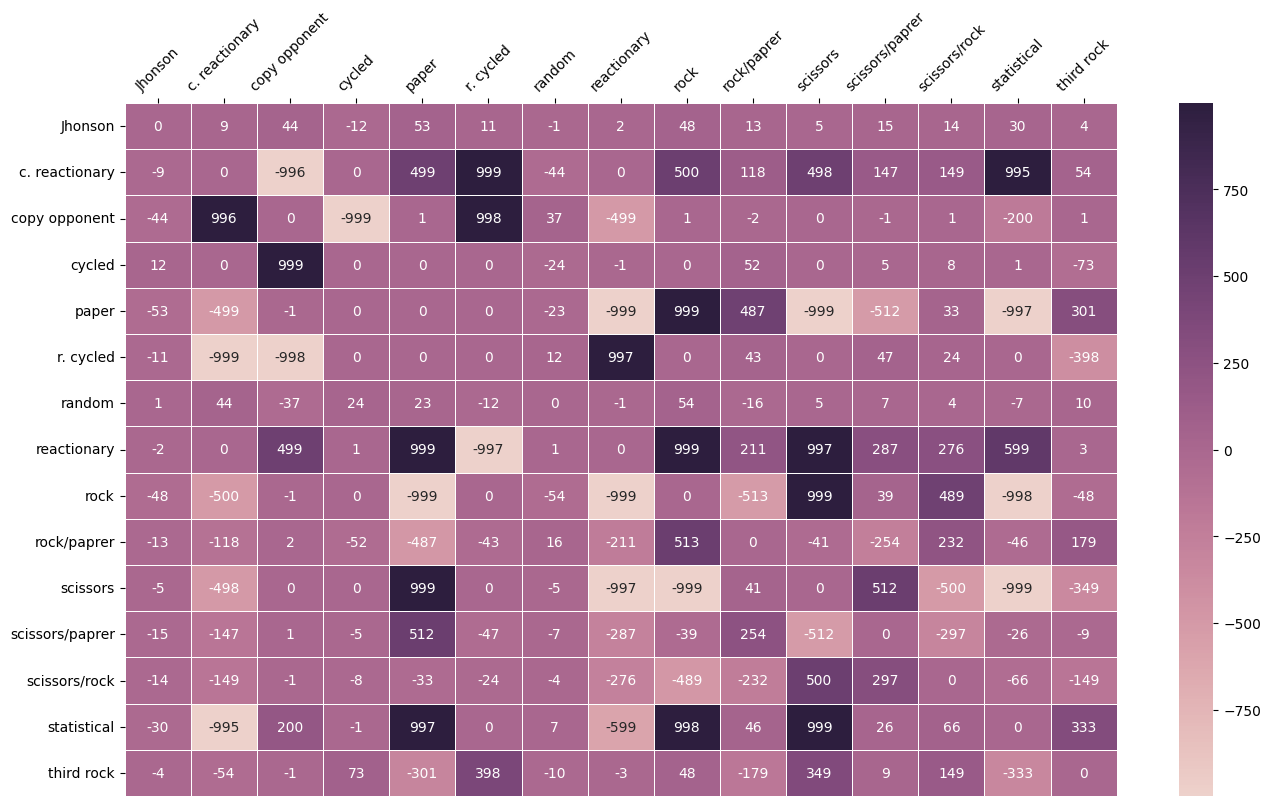

In [15]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.heatmap(
    scores_comparison,
    annot=True,
    fmt=".0f",
    cmap=sns.cubehelix_palette(as_cmap=True),
    ax=ax,
    linewidths=0.5,
)
ax.xaxis.tick_top()
ax.set(xlabel="", ylabel="")
ax.tick_params(axis="x", labelrotation=45)

Далее сгруппируем очки заработанные агентами и построим `barplot` с суммой выигранных игр со всеми оппонентами.

In [16]:
scores_by_agents = (
    df.groupby("agent")[["scores"]].sum().sort_values("scores", ascending=False)
)
scores_by_agents

,scores
agent,
reactionary,3873.0
c. reactionary,2910.0
statistical,2047.0
cycled,979.0
copy opponent,290.0
Jhonson,235.0
third rock,141.0
random,99.0
rock/paprer,-323.0


На графике мы можем увидеть лидеров по играм:

1. `statistiacal` агент выиграл большинство игр с агентами и больше всех среди других агентов, что понятно, т.к. он старается статистически предсказать правильный контрудар на основании предыдущих ходов противника.
2. `reactionary` агент занимает вторую позицию, что не удивительно, т.к. старается реагировать на действия противника. Из предыдущего графика мы знаем что `statistical` сильно проиграл `reactionary`, что примечательно. Лидер по всем играм не может противостоять этой стратегии потому что собранная статистика не может адаптироваться к этой модели, т.к. она постоянно реагирует противоположным ходом. 
3. агенты `paper`, `rock` и `scissors` ожидаемо выиграли меньше всего игр и больше всего проиграли. Это самые простые агенты которые всегда возвращают строго одно значение.

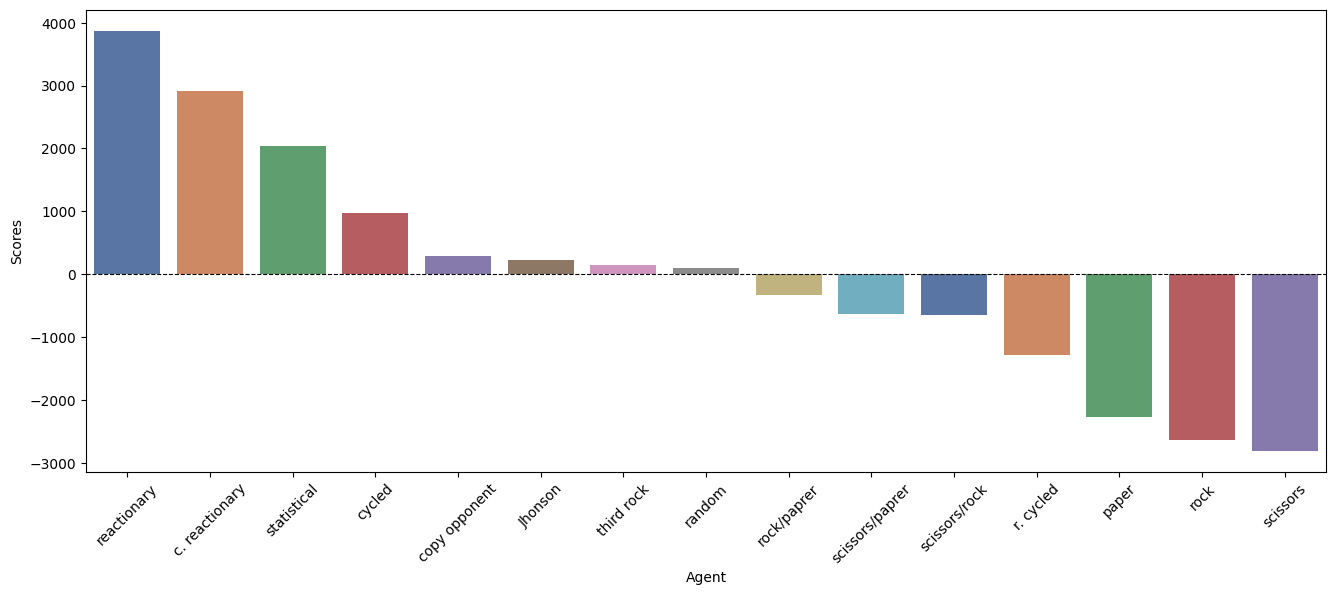

In [17]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(
    x=scores_by_agents.index,
    y=scores_by_agents["scores"],
    hue=scores_by_agents.index,
    palette="deep",
    ax=ax,
)
ax.axhline(0, color="k", clip_on=True, linestyle="--", linewidth=0.8)
ax.set_ylabel("Scores")
ax.set_xlabel("Agent")
ax.tick_params(axis="x", labelrotation=45)